<H1 style="text-align: center;">Hypoglycemia Detection</H1>
<H3 style="text-align: center;">EDA</H3>
###Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import copy

In [ ]:
###Read Cleaned Data From File

In [3]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


###Aggregate Dataframe to Visualise various features

In [150]:
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'mean' : group_df['Blood_Glucose'].mean(),
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'lows_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']<70]['Blood_Glucose'].count()
                                   /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE') |
                            (group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days))
})

df_agg.head()

,exercise_perday,highs_perday,hypos_perday,insulin_perday,irregular_perday,lows_perday,mean,median,nph_insulin_perday,readings_perday,regular_insulin_perday,snacks_perday,std,ultralente_insulin_perday
Patient_ID,,,,,,,,,,,,,,
1,0.0,0.762963,0.362963,3.674074,0.000000,4.222222,67.783333,67.783333,0.970370,6.666667,2.703704,0.000000,85.840507,0.000000
2,0.0,1.715789,0.000000,3.926316,0.000000,4.105263,100.045205,100.045205,0.021053,7.684211,3.905263,0.000000,105.922854,0.000000
3,0.0,0.657895,0.078947,3.421053,0.263158,4.394737,70.313793,70.313793,0.026316,7.631579,1.552632,0.394737,80.270788,1.842105
4,0.0,1.131579,0.026316,3.684211,0.157895,4.342105,82.479310,82.479310,1.421053,7.631579,1.789474,0.842105,96.339767,0.473684
5,0.0,1.100000,0.000000,3.600000,0.050000,4.050000,85.882759,85.882759,1.875000,7.250000,1.725000,0.900000,98.199818,0.000000


###Make The Aggregated Dataframe plotable by using pd.melt

In [151]:
df_agg_plot = df_agg.reset_index().drop('Patient_ID', axis = 1)

df_agg_plot['Hypo_Flag'] = 'Non_Hypoglycemic'

df_agg_plot.loc[df_agg_plot['hypos_perday']>0.0, 'Hypo_Flag'] = 'Hypoglycemic'

df_agg_plot['Hypo_Flag'].unique()

df_agg_plot = pd.melt(df_agg_plot, id_vars=['Hypo_Flag'], var_name='params')

df_agg_plot.head()

,Hypo_Flag,params,value
0,Hypoglycemic,exercise_perday,0.0
1,Non_Hypoglycemic,exercise_perday,0.0
2,Hypoglycemic,exercise_perday,0.0
3,Hypoglycemic,exercise_perday,0.0
4,Non_Hypoglycemic,exercise_perday,0.0


<H3 style="text-align: center;">Plotting</H3>
###The below plot compares the median and STD of the hypoglycemic and non hypoglycemic people in the dataset.
Note : A patient is considered hypoglycemic if the patient has had atleast one hypoglycemic symptom.
    A patient is considered non hypoglycemic if the patient has had ZERO hypoglycemic symptoms

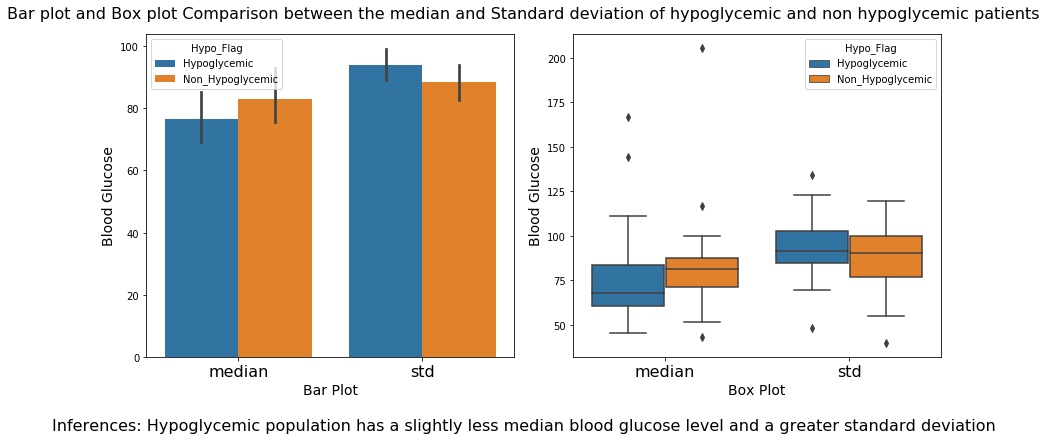

In [152]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plt.suptitle('Bar plot and Box plot Comparison between the median and Standard deviation of hypoglycemic and non hypoglycemic patients', fontsize=16)
#plt.subplots_adjust(top=2)
sns.barplot(x="params", y="value", hue="Hypo_Flag", 
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'median') | (df_agg_plot['params']  == 'std')], ax=ax1)
ax1.set_xlabel('Bar Plot', fontsize=14)
ax1.set_ylabel('Blood Glucose', fontsize=14)
ax1.tick_params(axis='x', which='major', labelsize=16)

sns.boxplot(x="params", y="value", hue="Hypo_Flag", 
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'median') | (df_agg_plot['params']  == 'std')], ax=ax2)    
ax2.set_xlabel('Box Plot', fontsize=14)
ax2.set_ylabel('Blood Glucose', fontsize=14)

fig.set_size_inches(12, 6)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
ax2.tick_params(axis='x', which='major', labelsize=16)
fig.text(0.5, 0,'Inferences: Hypoglycemic population has a slightly less median '+
         'blood glucose level and a greater standard deviation',
     horizontalalignment='center',
     verticalalignment='baseline',
     size=16)
plt.show()

In [153]:
print('Median Quantiles for hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']>0.0, 'median'].quantile([.25,.5,.75]),
      '\nMedian Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'median'].quantile([.25,.5,.75]),
      '\nSTD Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'std'].quantile([.25,.5,.75]),
      '\nSTD Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'std'].quantile([.25,.5,.75]))

Median Quantiles for hypoglycemic patients
 0.25    60.710345
0.50    67.736494
0.75    83.864003
Name: median, dtype: float64 
Median Quantiles for non hypoglycemic patients
 0.25    71.086207
0.50    81.196766
0.75    87.540289
Name: median, dtype: float64 
STD Quantiles for non hypoglycemic patients
 0.25     76.963331
0.50     90.613977
0.75    100.066212
Name: std, dtype: float64 
STD Quantiles for non hypoglycemic patients
 0.25     76.963331
0.50     90.613977
0.75    100.066212
Name: std, dtype: float64


In [ ]:
###Below Plot Compares the different habits of hypoglycemic and non hypoglycemic populations.
Note : The 

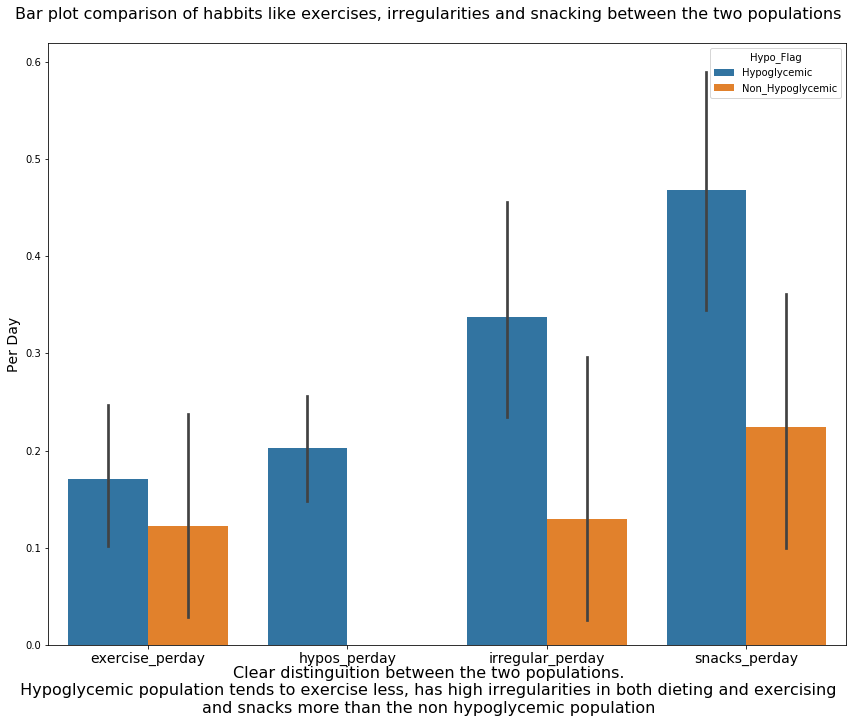

In [154]:
fig = plt.gcf()
plt.suptitle('Bar plot comparison of habbits like exercises, irregularities and snacking between the two populations', fontsize=16)
fig.set_size_inches(12, 10, forward=True)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", 
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'exercise_perday') | 
                                 (df_agg_plot['params']  == 'hypos_perday') | 
                                 (df_agg_plot['params']  == 'irregular_perday') | 
                                 (df_agg_plot['params']  == 'snacks_perday')])    

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Per Day', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)
fig.text(0.5, 0,'Clear distinguition between the two populations.\n '+
         'Hypoglycemic population tends to exercise less, has high irregularities in both dieting and exercising '+
         '\nand snacks more than the non hypoglycemic population',
     horizontalalignment='center',
     verticalalignment='baseline',
     size=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()



In [149]:
print('Exercise Per Day Quantiles for hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']>0.0, 'exercise_perday'].quantile([.25,.5,.75]),
      '\Exercise Per Day Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'exercise_perday'].quantile([.25,.5,.75]),
      '\nIrregular diet and exercises Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'irregular_perday'].quantile([.25,.5,.75]),
      '\nIrregular diet and exercises Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'irregular_perday'].quantile([.25,.5,.75]),
      '\nSnack Per Day Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'snacks_perday'].quantile([.25,.5,.75]),
      '\nSnacks Per Day Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'snacks_perday'].quantile([.25,.5,.75]))

Exercise Per Day Quantiles for hypoglycemic patients
 0.25    0.000000
0.50    0.000000
0.75    0.034195
Name: exercise_perday, dtype: float64 \Exercise Per Day Quantiles for non hypoglycemic patients
 0.25    0.0
0.50    0.0
0.75    0.0
Name: exercise_perday, dtype: float64 
Irregular diet and exercises Quantiles for non hypoglycemic patients
 0.25    0.0000
0.50    0.0000
0.75    0.0305
Name: irregular_perday, dtype: float64 
Irregular diet and exercises Quantiles for non hypoglycemic patients
 0.25    0.0000
0.50    0.0000
0.75    0.0305
Name: irregular_perday, dtype: float64 
Snack Per Day Quantiles for non hypoglycemic patients
 0.25    0.000000
0.50    0.000000
0.75    0.449049
Name: snacks_perday, dtype: float64 
Snacks Per Day Quantiles for non hypoglycemic patients
 0.25    0.000000
0.50    0.000000
0.75    0.449049
Name: snacks_perday, dtype: float64


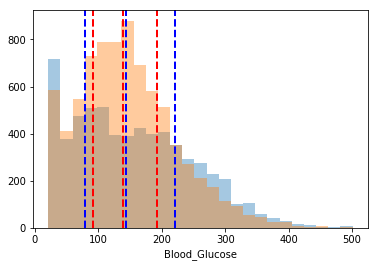

In [188]:
#plt.hist(x, bins, alpha=0.5, label='x')
#plt.hist(y, bins, alpha=0.5, label='y')
#pyplot.legend(loc='upper right')
df['Hypo_Flag'] = False
df.loc[df['Patient_ID'].isin(df.loc[df['Code_Description'] == 'HYPOGLYCEMIC_SYMPTOMS', 'Patient_ID'].unique()),'Hypo_Flag'] = True 

df[df['Hypo_Flag']==True].head()

sns.distplot(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'],  kde=False, bins=25)
sns.distplot(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'],  kde=False, bins=25)

plt.axvline(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].median(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.25), color='b', linestyle='dashed', linewidth=2)
plt.axvline(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.75), color='b', linestyle='dashed', linewidth=2)


plt.axvline(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].median(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.25), color='r', linestyle='dashed', linewidth=2)
plt.axvline(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.75), color='r', linestyle='dashed', linewidth=2)
plt.show()
#df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>0),'Blood_Glucose']